<a href="https://colab.research.google.com/github/mahdiimanzadeh/Image-Classification-of-Vegetables-with-Noise-Augmentation/blob/main/Mahdi_Imanzadeh_Acc_92_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copy and Unzip the dataset

In [ ]:
import gdown
file_id = "1-DFgrzdBgVzXGYm_wRPas2q80tpPGWVH"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="Kelaasor_vegetable_images_dataset.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-DFgrzdBgVzXGYm_wRPas2q80tpPGWVH
From (redirected): https://drive.google.com/uc?id=1-DFgrzdBgVzXGYm_wRPas2q80tpPGWVH&confirm=t&uuid=ebf261de-0a49-4048-be4b-a021ba3360d3
To: /content/Kelaasor_vegetable_images_dataset.zip
100%|██████████| 1.46G/1.46G [00:24<00:00, 60.2MB/s]


'Kelaasor_vegetable_images_dataset.zip'

In [ ]:
#!cp drive/MyDrive/Kelaasor_vegetable_images_dataset.zip .
!unzip -q Kelaasor_vegetable_images_dataset.zip

## USE DRIVE TO SAVE MODEL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset and Dataloader

In [ ]:
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

## Initialize list to store dimensions (height, width, channels)

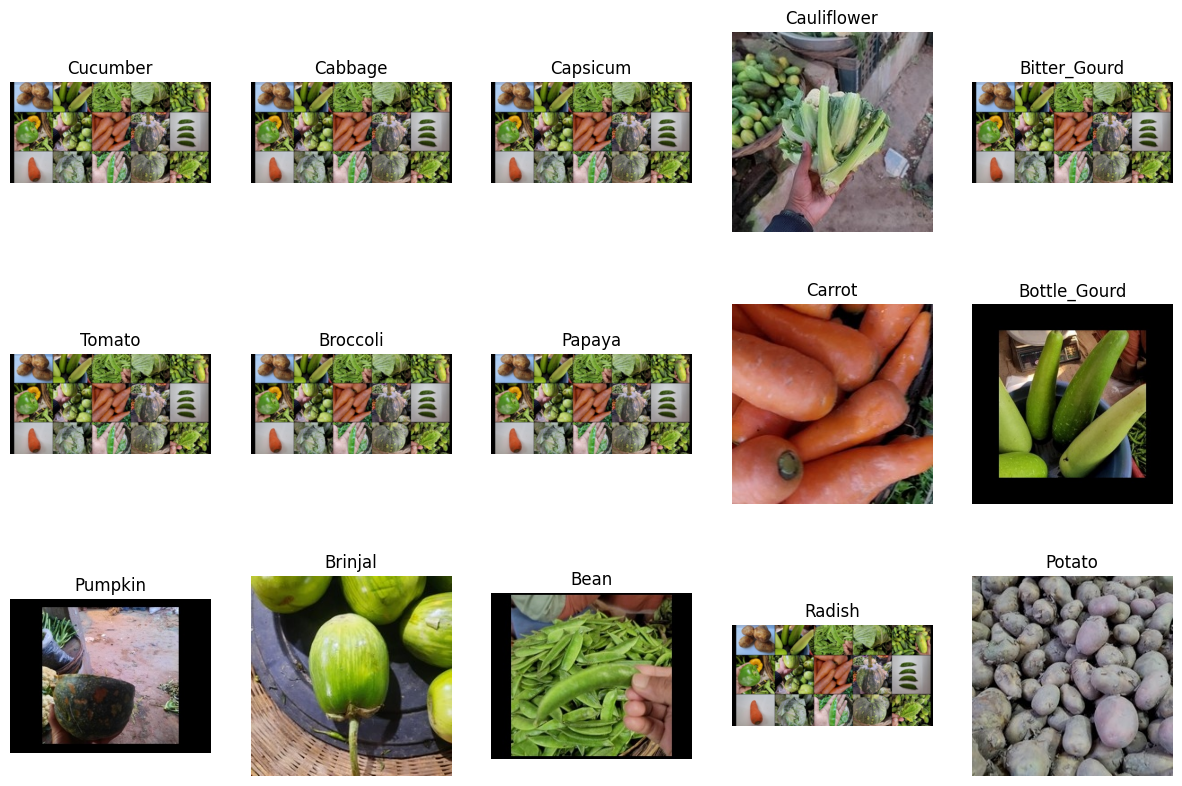

In [ ]:
import os
import cv2
train_dir = "/content/Kelaasor_vegetable_images_dataset/train"
image_dimensions = []

# Get list of classes
classes = os.listdir(train_dir)

plt.figure(figsize=(15, 10))

# Loop through each class and process the images
for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)

    # Read the first image in the class directory
    image_path = os.path.join(class_dir, images[0])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Save height, width, and number of channels
    height, width, channels = image.shape
    image_dimensions.append((height, width, channels))

    # Plot the image
    plt.subplot(3, 5, i+1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')

plt.show()

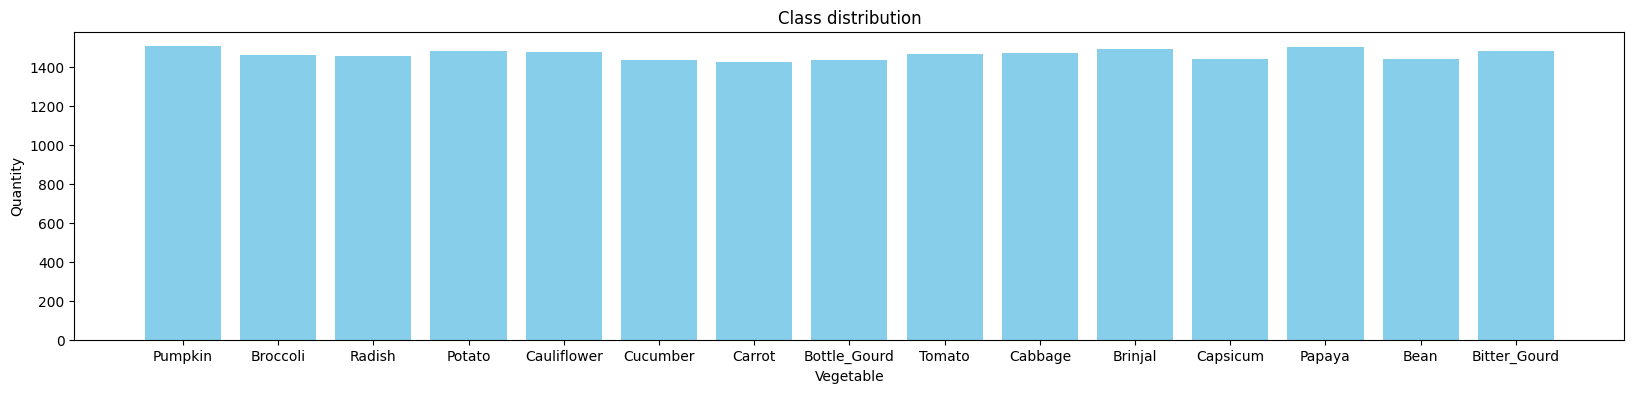

In [ ]:
count_dict = {}

for root, dirs, files in os.walk(train_dir):
    clase = os.path.basename(root)
    count_dict[clase] = len(files)

lables = list(count_dict.keys())[1:]
count = list(count_dict.values())[1:]
plt.figure(figsize=(20,4))
plt.bar(lables, count, color="skyblue")
plt.title("Class distribution")
plt.xlabel("Vegetable")
plt.ylabel("Quantity")
plt.show()

In [ ]:
# Low blur, salt and pepper, grayscale Images are noises of test and validation dataset

## Importing the data, transformations and creating DataLoaders¶


In [ ]:
class AddNoise:
    def __init__(self, blur_prob=0.3, bw_prob=0.1, sp_prob=0.2):
        self.blur_prob = blur_prob
        self.bw_prob = bw_prob
        self.sp_prob = sp_prob

    def __call__(self, tensor):
        if random.random() < self.blur_prob:
            tensor = transforms.functional.gaussian_blur(tensor, kernel_size=[3,5])

        if random.random() < self.bw_prob:
            tensor = transforms.functional.rgb_to_grayscale(tensor, num_output_channels=3)

        if random.random() < self.sp_prob:
            noise = torch.rand_like(tensor)
            tensor[noise < 0.01] = 0
            tensor[noise > 0.99] = 1

        return tensor

In [ ]:
clean_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Second Step Transformations
noisy_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    AddNoise(blur_prob=0.5, bw_prob=0.3, sp_prob=0.4),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# validation/test (without augmentation)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = ImageFolder("/content/Kelaasor_vegetable_images_dataset/train", transform=clean_transform)
valid_dataset = ImageFolder("/content/Kelaasor_vegetable_images_dataset/validation", transform=test_transform)
test_dataset = ImageFolder("/content/Kelaasor_vegetable_images_dataset/test", transform=test_transform)

In [ ]:
from IPython.core.display import HTML,display
import random
import torchvision

## Visualize samples

In [ ]:
def plot_original_and_aug_image(target_dir,aug_list):
    """
    takes the directory as input and prints 1 random images from the randomly choosen class with without augmentation for each augmentation passed.
    """
    n=len(aug_list)
    display(HTML('<H2 style="color:green"> <b>Data Augmentation</b></H2><hr>'))
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),n)


    for i in range(n):
        plt.figure(figsize=(16,6))
        augmentation=aug_list[i]
        plt.subplot(1,2,1)
        img=torchvision.io.read_image(os.path.join(target_folder,random_image[i]))
        img=img/255.0
        plt.imshow(np.array(img).transpose(1,2,0))
        plt.title(f'Original Image\n{target_class}\n{np.array(img).shape}')
        plt.xticks([]);
        plt.yticks([])

        plt.subplot(1,2,2)

        img=augmentation(img)


        plt.imshow(np.array(img).transpose(1,2,0))
        plt.title(f'Augmented Image:{augmentation}\n{target_class}\n{np.array(img).shape}')
        plt.xticks([]);
        plt.yticks([])
        plt.show()
        display(HTML('<hr>'))

In [ ]:
plot_original_and_aug_image(train_dir,augmentation_list)

## Dataloaders

In [ ]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size,shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size,shuffle=True, num_workers=2)

# Load Pretrained mobilenet model

In [ ]:
import torchvision.models as models


In [ ]:
def create_model():
    model = models.mobilenet_v2(pretrained=True)

    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(1280, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 15)
    )

    for param in model.features.parameters():
        param.requires_grad = False

    return model

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for X, y in pbar:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()
        total_loss += loss.item()

        pbar.set_postfix({
            'loss': total_loss/(total/len(y)),
            'acc': 100.*correct/total
        })

    return total_loss/len(loader), 100.*correct/total

In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation", leave=False)
        for X, y in pbar:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)

            _, preds = outputs.max(1)
            total += y.size(0)
            correct += preds.eq(y).sum().item()
            total_loss += loss.item()

            pbar.set_postfix({
                'loss': total_loss/(total/len(y)),
                'acc': 100.*correct/total
            })

    return total_loss/len(loader), 100.*correct/total

In [ ]:
def train_two_stage(model, train_loader, valid_loader, epochs=15):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW([
        {'params': model.features.parameters(), 'lr': 1e-5},
        {'params': model.classifier.parameters(), 'lr': 3e-4}
    ], weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    best_acc = 0

    # Stage 1: train clean dataset
    print("=== Stage 1: Clean Data Training ===")
    for epoch in range(5):
        print(f"\nEpoch {epoch+1}/{5}")
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, valid_loader, criterion, device)

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model_stage1.pth')

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")

    # Stage 2: Fine-tuning with noisy data
    print("\n=== Stage 2: Noisy Data Fine-Tuning ===")
    train_loader.dataset.transform = noisy_transform

    for param in model.features.parameters():
        param.requires_grad = True

    for epoch in range(5, epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, valid_loader, criterion, device)

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model_stage2.pth')

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")

    return model

In [ ]:
model = create_model()
trained_model = train_two_stage(model, train_dataloader, valid_dataloader, epochs=20)

=== Stage 1: Clean Data Training ===

Epoch 1/5


<ipython-input-16-06e8085667b1>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(loader, desc="Training", leave=False)


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.5425 | Acc: 51.93%
Val Loss: 0.5091 | Acc: 85.90%

Epoch 2/5


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.3643 | Acc: 56.05%
Val Loss: 0.4717 | Acc: 86.77%

Epoch 3/5


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.3282 | Acc: 56.89%
Val Loss: 0.4209 | Acc: 87.80%

Epoch 4/5


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.3136 | Acc: 57.11%
Val Loss: 0.3654 | Acc: 89.13%

Epoch 5/5


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.3016 | Acc: 57.83%
Val Loss: 0.3517 | Acc: 89.57%

=== Stage 2: Noisy Data Fine-Tuning ===

Epoch 6/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.1907 | Acc: 61.06%
Val Loss: 0.3166 | Acc: 90.73%

Epoch 7/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.1329 | Acc: 63.04%
Val Loss: 0.2882 | Acc: 91.77%

Epoch 8/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0920 | Acc: 64.09%
Val Loss: 0.2903 | Acc: 91.60%

Epoch 9/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0672 | Acc: 64.67%
Val Loss: 0.2715 | Acc: 92.03%

Epoch 10/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0585 | Acc: 64.90%
Val Loss: 0.3088 | Acc: 91.53%

Epoch 11/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0422 | Acc: 65.56%
Val Loss: 0.2561 | Acc: 92.30%

Epoch 12/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0394 | Acc: 65.52%
Val Loss: 0.2383 | Acc: 92.57%

Epoch 13/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0276 | Acc: 65.94%
Val Loss: 0.2367 | Acc: 92.83%

Epoch 14/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0267 | Acc: 66.07%
Val Loss: 0.2477 | Acc: 92.37%

Epoch 15/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdva

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0171 | Acc: 66.33%
Val Loss: 0.2265 | Acc: 93.23%

Epoch 16/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0223 | Acc: 66.28%
Val Loss: 0.2325 | Acc: 93.27%

Epoch 17/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0061 | Acc: 66.89%
Val Loss: 0.2428 | Acc: 92.47%

Epoch 18/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0094 | Acc: 66.59%
Val Loss: 0.2366 | Acc: 92.90%

Epoch 19/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0132 | Acc: 66.56%
Val Loss: 0.1923 | Acc: 94.53%

Epoch 20/20


Training:   0%|          | 0/687 [00:00<?, ?it/s]

<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:792.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:16: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1991.)
  tensor[noise < 0.01] = 0  # فلفل
<ipython-input-7-6aeb454572a1>:17: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdv

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 1.0125 | Acc: 66.47%
Val Loss: 0.2201 | Acc: 93.37%


In [ ]:
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for X, y in tqdm(loader, desc="Evaluating"):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, preds = outputs.max(1)
            total += y.size(0)
            correct += preds.eq(y).sum().item()

    return 100. * correct / total

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_acc = evaluate(trained_model, test_dataloader, device)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

<ipython-input-27-ef0b0ad16f29>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for X, y in tqdm(loader, desc="Evaluating"):


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]


Final Test Accuracy: 91.37%
